In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import warnings

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [25]:
warnings.filterwarnings("ignore")

scaler =MinMaxScaler()

# 1. Reading and Understanding Data

In [26]:
bikesharing_df=pd.read_csv('day.csv')

print(bikesharing_df.info())
bikesharing_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Observations
- There are 730 rows with no null or missing values
- There are categorical variables such as - yr,mnth,weekday,season,weathersit,workingday,holiday
- Dummy variables needs to be created for mnth,weekday,season,weathersit
- Variables such as yr,workingday,holiday are already in numeric format hence there is no need to create dummy varibles for them


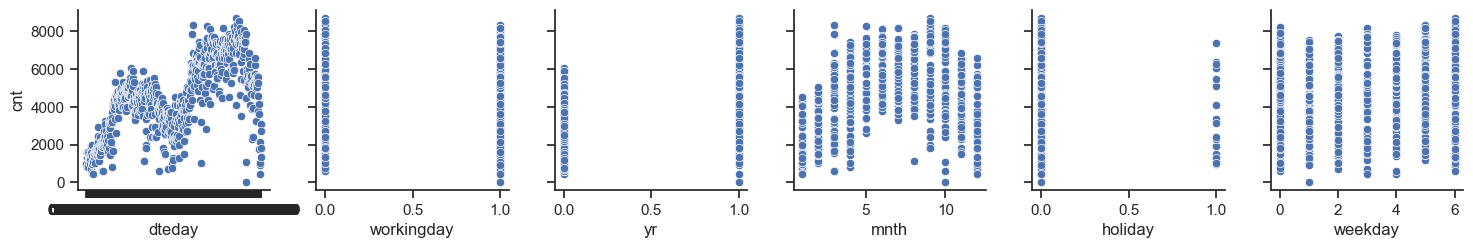

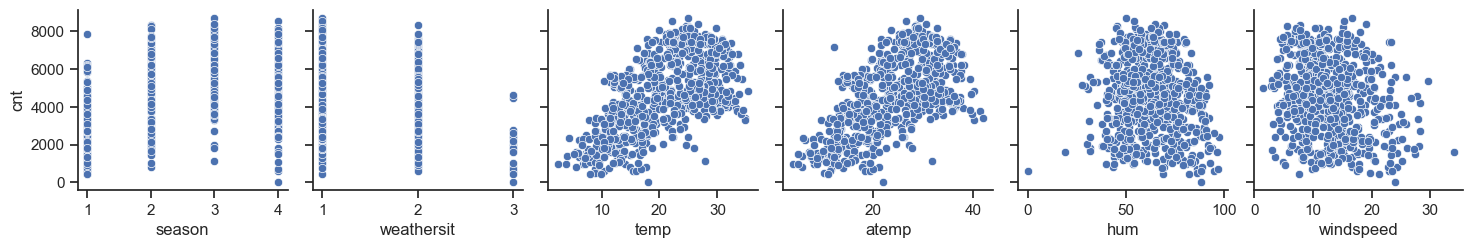

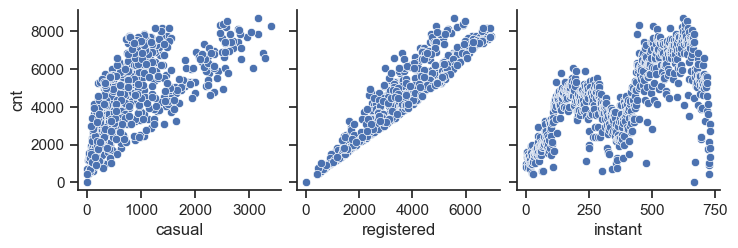

In [27]:
# Pair plot to identify relationships between variables
sns.pairplot(data=bikesharing_df, y_vars='cnt',x_vars=['dteday', 'workingday', 'yr', 'mnth','holiday','weekday'])
sns.pairplot(data=bikesharing_df, y_vars='cnt',x_vars=['season','weathersit','temp', 'atemp','hum','windspeed'])
sns.pairplot(data=bikesharing_df, y_vars='cnt',x_vars=['casual', 'registered','instant'])
plt.show()


### Observations
- Varibale instant is a record index, hence is of no significance.
- Although a linear relationship can be seen between dteday and cnt, but it can be ignored as there are other columns such as workinday, weekday, holiday which seem to be more relevant to have an impact on the target variable cnt.
- Variables such as casual and registered can also be ignored as cnt is the direct sum of these variables. A model built using these variables may be biased and might not be able to explain the impact of other variables to its full extent.
- As per the plot 'workingday', 'yr', 'mnth','holiday','weekday','season','weathersit','temp', 'atemp','hum','windspeed' can be good candidates for linear regression model.

# 2. Data Preparation

### Dummy encoding

In [28]:
# Extracting out the data frame with relevant variables
bike_df_new=bikesharing_df[['season', 'yr', 'mnth', 'holiday', 'weekday','workingday', 
              'weathersit', 'temp', 'atemp', 'hum', 'windspeed','cnt']]

# Dummy encoding for categorical variables
def monthName(monthNumber):
    return calendar.month_name[monthNumber]

def dayName(dayNumber):
    return calendar.day_name[dayNumber]

def seasonName(seasonIdentifier):
    if seasonIdentifier==1:
        return 'spring'
    if seasonIdentifier==2:
        return 'summer'
    if seasonIdentifier==3:
        return 'fall'
    if seasonIdentifier==4:
        return 'winter'
    
def weatherName(weatherIdentifier):
    if weatherIdentifier==1:
        return 'clear'
    if weatherIdentifier==2:
        return 'mist'
    if weatherIdentifier==3:
        return 'light snow'
    if weatherIdentifier==4:
        return 'heavy rain'

bike_df_new['mnth']=bike_df_new['mnth'].apply(monthName)
bike_df_new['weekday']=bike_df_new['weekday'].apply(dayName)
bike_df_new['season']=bike_df_new['season'].apply(seasonName)
bike_df_new['weathersit']=bike_df_new['weathersit'].apply(weatherName)

dummyVariables=['mnth','weekday','season','weathersit']

seasons=pd.get_dummies(bike_df_new['season'],drop_first=True)
bike_df_new=pd.concat([bike_df_new,seasons],axis=1)

weathersit=pd.get_dummies(bike_df_new['weathersit'],drop_first=True)
bike_df_new=pd.concat([bike_df_new,weathersit],axis=1)

weekday=pd.get_dummies(bike_df_new['weekday'],drop_first=True)
bike_df_new=pd.concat([bike_df_new,weekday],axis=1)


mnth=pd.get_dummies(bike_df_new['mnth'],drop_first=True)
bike_df_new=pd.concat([bike_df_new,mnth],axis=1)


bike_df_new=bike_df_new.drop(columns=dummyVariables)
bike_df_new.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,December,February,January,July,June,March,May,November,October,September
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,1,0,0,0,0,0,0,0


### Test and Train split

In [29]:
bikesharing_train_df, bikesharing_test_df=train_test_split(bike_df_new,train_size=.7, 
                                                               test_size = 0.3,random_state=100)
print('train data ',bikesharing_train_df.shape)
print('test data ',bikesharing_test_df.shape)

train data  (510, 30)
test data  (219, 30)


### Scale Variables

In [30]:
variables_to_scale=['temp','atemp','hum','windspeed','cnt']

bikesharing_train_df[variables_to_scale]=scaler.fit_transform(bikesharing_train_df[variables_to_scale])
bikesharing_train_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,December,February,January,July,June,March,May,November,October,September
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,...,0,0,0,0,0,0,0,0,1,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,0,0,0,0,0,0,0


# 3. Train the model

### Plot HeatMap to understand the co-relation

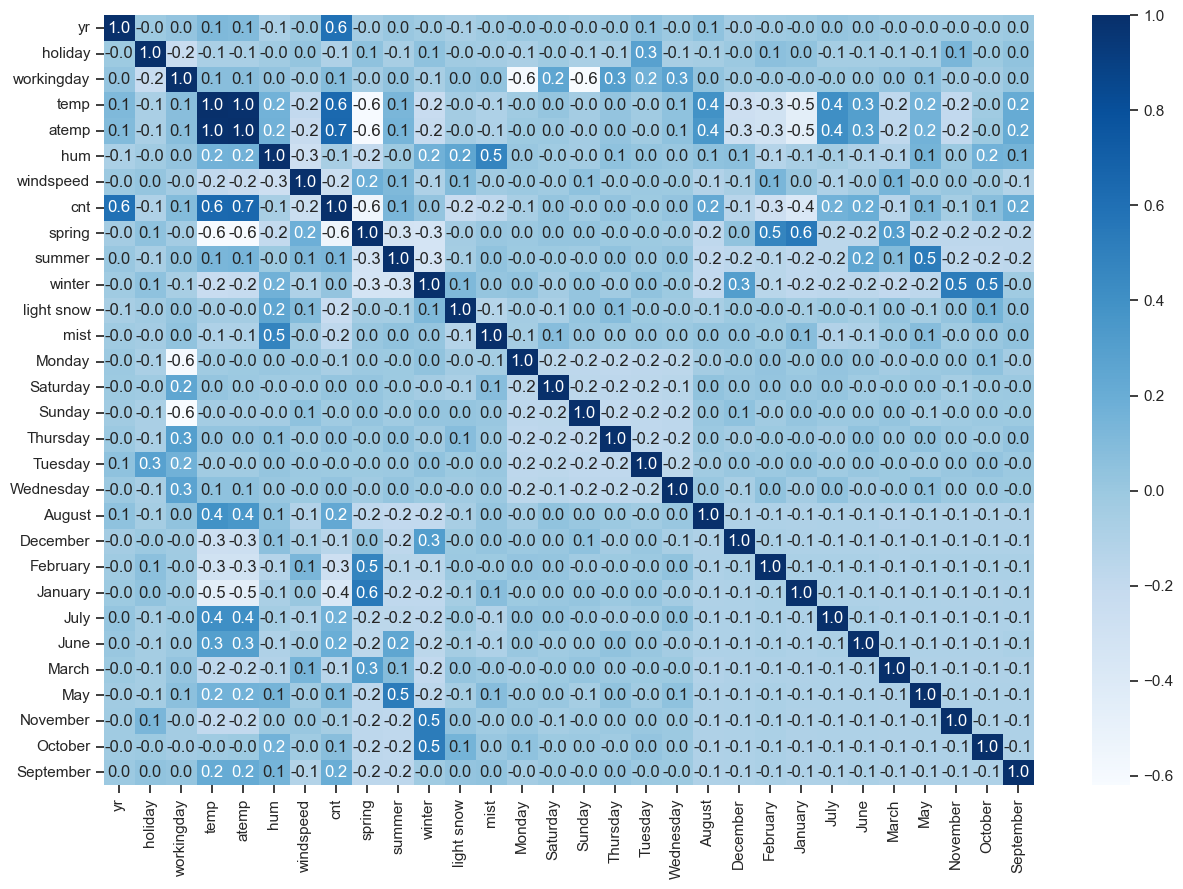

In [31]:
plt.figure(figsize=(15, 10))
sns.heatmap(round(bikesharing_train_df.corr(),2), annot=True, fmt=".1f", cmap="Blues")
plt.show()

### Observations
- Heatmap shows cnt has a strong co-relation with variables such as temp, atemp, yr, spring.
- There is a medium corelation with variables such as January, Feburary, September, June, July, August, etc.
- There are around 15 variables with which cnt depicts some co-relations.

### Extracting out x_train and y_train

In [32]:
y_bikesharing_train =bikesharing_train_df.pop('cnt')
x_bikesharing_train =bikesharing_train_df
print(x_bikesharing_train.columns)
print(y_bikesharing_train)

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'spring', 'summer', 'winter', 'light snow', 'mist', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September'],
      dtype='object')
653    0.864243
576    0.827658
426    0.465255
728    0.204096
482    0.482973
         ...   
526    0.764151
578    0.832835
53     0.218017
350    0.312586
79     0.236424
Name: cnt, Length: 510, dtype: float64


### Feature Selection by using RFE

In [33]:
linearModel=LinearRegression()
linearModel.fit(x_bikesharing_train,y_bikesharing_train)

rfe=RFE(linearModel, n_features_to_select=15)
rfe=rfe.fit(x_bikesharing_train,y_bikesharing_train)

feature_ranking=list(zip(x_bikesharing_train.columns,rfe.support_,rfe.ranking_))

feature_ranking


[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('light snow', True, 1),
 ('mist', True, 1),
 ('Monday', True, 1),
 ('Saturday', False, 11),
 ('Sunday', True, 1),
 ('Thursday', False, 13),
 ('Tuesday', False, 9),
 ('Wednesday', False, 10),
 ('August', False, 8),
 ('December', False, 3),
 ('February', False, 5),
 ('January', False, 2),
 ('July', True, 1),
 ('June', False, 14),
 ('March', False, 15),
 ('May', False, 7),
 ('November', False, 4),
 ('October', False, 12),
 ('September', True, 1)]

In [34]:
print('Feature Ranking by RFE : \n',feature_ranking)
rfeColLst=list(x_bikesharing_train.columns[rfe.support_])
print('\n')

print('Columns selected by RFE: \n',x_bikesharing_train.columns[rfe.support_])
print('\n')
print('Columns not selected by RFE: \n',x_bikesharing_train.columns[~rfe.support_])


x_bikesharing_rfe_train=x_bikesharing_train[rfeColLst]
x_bikesharing_rfe_train.head()


Feature Ranking by RFE : 
 [('yr', True, 1), ('holiday', True, 1), ('workingday', True, 1), ('temp', True, 1), ('atemp', False, 6), ('hum', True, 1), ('windspeed', True, 1), ('spring', True, 1), ('summer', True, 1), ('winter', True, 1), ('light snow', True, 1), ('mist', True, 1), ('Monday', True, 1), ('Saturday', False, 11), ('Sunday', True, 1), ('Thursday', False, 13), ('Tuesday', False, 9), ('Wednesday', False, 10), ('August', False, 8), ('December', False, 3), ('February', False, 5), ('January', False, 2), ('July', True, 1), ('June', False, 14), ('March', False, 15), ('May', False, 7), ('November', False, 4), ('October', False, 12), ('September', True, 1)]


Columns selected by RFE: 
 Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'summer', 'winter', 'light snow', 'mist', 'Monday', 'Sunday', 'July',
       'September'],
      dtype='object')


Columns not selected by RFE: 
 Index(['atemp', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday', 'August',


,yr,holiday,workingday,temp,hum,windspeed,spring,summer,winter,light snow,mist,Monday,Sunday,July,September
653,1,0,1,0.509887,0.575354,0.300794,0,0,1,0,0,0,0,0,0
576,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,0,0,0,1,0
426,1,0,0,0.442393,0.640189,0.255342,1,0,0,0,1,0,1,0,0
728,1,0,0,0.245101,0.498067,0.663106,1,0,0,0,0,1,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0,1,0,0,1,0,1,0,0


### Building model using statsmodel and analyzing it

In [35]:
# Adding constant
x_bikesharing_rfe_train_sm =sm.add_constant(x_bikesharing_rfe_train)

# Fitting Model
linear_model=sm.OLS(y_bikesharing_train,x_bikesharing_rfe_train_sm).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          1.13e-191
Time:                        12:30:59   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1989      0.028      7.181      0.0

### Calculate VIF

In [36]:
# Calculating VIF
vif_df=pd.DataFrame()
vif_cols=x_bikesharing_rfe_train.columns
vif_df['features']=vif_cols
vif_df['vif']=[variance_inflation_factor(x_bikesharing_rfe_train.values,i) for i in range(x_bikesharing_rfe_train.shape[1])]
vif_df['vif']=round(vif_df['vif'],2)
vif_df.sort_values(by='vif', ascending=False)

,features,vif
2,workingday,50.69
12,Sunday,12.20
11,Monday,11.79
6,spring,5.02
3,temp,3.62
8,winter,3.49
1,holiday,2.91
7,summer,2.61
4,hum,1.91
10,mist,1.57


## Observations
- The adjusted R-square of the model is quite good which is 84.3%
- It can be seen that P-Value for holiday is quite high which is 0.373, greater than .05
- VIF for workingday, Sunday, Monday are quite high.
- As per the rule we should remove variables with high P-value one by one.

### Remove varibale holiday and build the model

In [37]:
# Removing holiday
x_bikesharing_rfe_train=x_bikesharing_rfe_train.drop(['holiday'],axis=1)

# Adding constant
x_bikesharing_rfe_train_sm=sm.add_constant(x_bikesharing_rfe_train)

# Fitting Model
linearModel=sm.OLS(y_bikesharing_train,x_bikesharing_rfe_train_sm).fit()
print(linearModel.summary())

# Calculating VIF
vifDf=pd.DataFrame()
# tempDf=x_train_bikeSrRelavantDf[rfeColLst]

vifDf['features']=x_bikesharing_rfe_train.columns
vifDf['vif']=[variance_inflation_factor(x_bikesharing_rfe_train.values,i) for i in range(x_bikesharing_rfe_train.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf.sort_values(by='vif', ascending=False)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          1.13e-191
Time:                        12:30:59   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1799      0.042      4.276      0.0

,features,vif
3,hum,32.14
2,temp,18.98
1,workingday,18.41
11,Sunday,4.91
4,windspeed,4.90
5,spring,4.80
10,Monday,4.76
7,winter,3.71
6,summer,3.03
9,mist,2.31


## Observation
- The P-value of all the variables are now less than .05 which means they are significant.
- The adjusted R-square also remains the same i.e. 84.3%
- However there still some variables with very high VIF such as hum, temp, workinday.


### Removing variable hum with highest VIF

In [38]:
# Removing hum
x_bikesharing_rfe_train=x_bikesharing_rfe_train.drop(['hum'],axis=1)

# Adding constant
x_bikesharing_rfe_train_sm=sm.add_constant(x_bikesharing_rfe_train)

# Fitting Model
linearModel=sm.OLS(y_bikesharing_train,x_bikesharing_rfe_train_sm).fit()
print(linearModel.summary())

# Calculating VIF
vifDf=pd.DataFrame()
# tempDf=x_train_bikeSrRelavantDf[rfeColLst]

vifDf['features']=x_bikesharing_rfe_train.columns
vifDf['vif']=[variance_inflation_factor(x_bikesharing_rfe_train.values,i) for i in range(x_bikesharing_rfe_train.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf.sort_values(by='vif', ascending=False)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     203.0
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          5.73e-189
Time:                        12:31:00   Log-Likelihood:                 508.65
No. Observations:                 510   AIC:                            -989.3
Df Residuals:                     496   BIC:                            -930.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1005      0.038      2.618      0.0

,features,vif
1,workingday,16.19
2,temp,12.73
3,windspeed,4.75
10,Sunday,4.45
9,Monday,4.21
4,spring,3.82
6,winter,2.80
5,summer,2.75
0,yr,2.07
11,July,1.60


## Observations
- There is a slight decrease in the adjusted R-square from 84.3% to 83.8% which is not significant.
- P-Value for all the features are below .05
- The VIFs of workingday and temp as also reduced to some extent, but they are still greater than 5. Hence, needs to be removed.

### Removing variable workingday and re-building the model

In [39]:
# Removing workingday
x_bikesharing_rfe_train=x_bikesharing_rfe_train.drop(['workingday'],axis=1)

# Adding constant
x_bikesharing_rfe_train_sm=sm.add_constant(x_bikesharing_rfe_train)

# Fitting Model
linearModel=sm.OLS(y_bikesharing_train,x_bikesharing_rfe_train_sm).fit()
print(linearModel.summary())

# Calculating VIF
vifDf=pd.DataFrame()
# tempDf=x_train_bikeSrRelavantDf[rfeColLst]

vifDf['features']=x_bikesharing_rfe_train.columns
vifDf['vif']=[variance_inflation_factor(x_bikesharing_rfe_train.values,i) for i in range(x_bikesharing_rfe_train.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf.sort_values(by='vif', ascending=False)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     212.1
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          1.01e-186
Time:                        12:31:00   Log-Likelihood:                 500.52
No. Observations:                 510   AIC:                            -975.0
Df Residuals:                     497   BIC:                            -920.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2005      0.030      6.771      0.0

,features,vif
1,temp,5.17
2,windspeed,4.62
4,summer,2.23
3,spring,2.11
0,yr,2.07
5,winter,1.82
10,July,1.59
7,mist,1.55
11,September,1.33
9,Sunday,1.22


### Observations
- The VIFs of all the variables are now under control
- The P-value of variable Sunday has increased to .171
- The adjusted R-square is almost same.

### Removing variable Sunday and rebuilding the model

In [40]:
# Removing Sunday
x_bikesharing_rfe_train=x_bikesharing_rfe_train.drop(['Sunday'],axis=1)

# Adding constant
x_bikesharing_rfe_train_sm=sm.add_constant(x_bikesharing_rfe_train)

# Fitting Model
linearModel=sm.OLS(y_bikesharing_train,x_bikesharing_rfe_train_sm).fit()
print(linearModel.summary())

# Calculating VIF
vifDf=pd.DataFrame()
# tempDf=x_train_bikeSrRelavantDf[rfeColLst]

vifDf['features']=x_bikesharing_rfe_train.columns
vifDf['vif']=[variance_inflation_factor(x_bikesharing_rfe_train.values,i) for i in range(x_bikesharing_rfe_train.shape[1])]
vifDf['vif']=round(vifDf['vif'],2)
vifDf.sort_values(by='vif', ascending=False)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.8
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          1.65e-187
Time:                        12:31:00   Log-Likelihood:                 499.56
No. Observations:                 510   AIC:                            -975.1
Df Residuals:                     498   BIC:                            -924.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2036      0.030      6.889      0.0

,features,vif
1,temp,5.13
2,windspeed,4.60
4,summer,2.22
3,spring,2.09
0,yr,2.07
5,winter,1.80
9,July,1.59
7,mist,1.55
10,September,1.33
8,Monday,1.17


### Observations
- The adjusted R-square is almost same with value 83.2%
- All the variables have less P-value and less VIFs
- The P-value of F-statistics is negligible indicating that the linear model is an overall fit.


# 4. Validating Linear regression assumptions

Text(0, 0.5, 'residual error')

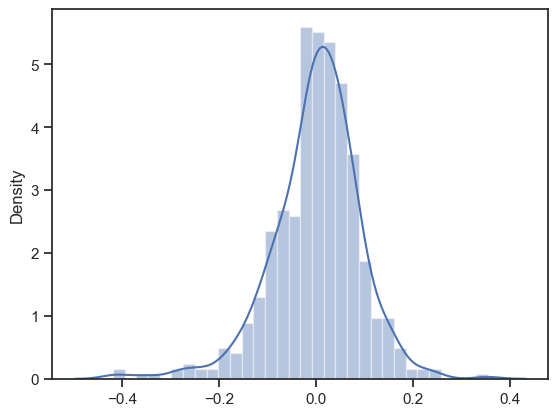

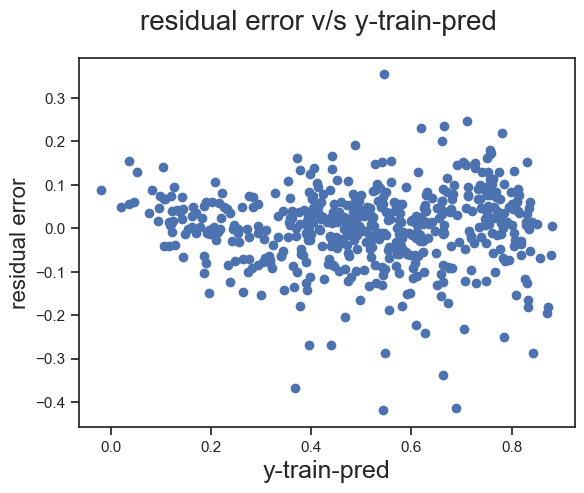

In [41]:
# Calculate the residual error
y_bikesharing_train_pred=linearModel.predict(x_bikesharing_rfe_train_sm)
residual_error=y_bikesharing_train-y_bikesharing_train_pred
sns.distplot(residual_error)

# Plotting residual error and y train to understand the patterns in error terms.
fig = plt.figure()
plt.scatter(x=y_bikesharing_train_pred,y= residual_error)
fig.suptitle('residual error v/s y-train-pred', fontsize=20)              # Plot heading 
plt.xlabel('y-train-pred', fontsize=18)                          # X-label
plt.ylabel('residual error', fontsize=16)                          # Y-label    

### Observations
- It can be seen from the first plot that the residual error are normally distributed with mean = 0.
- From the second plot it is clear that there is no pattern seen in the residual error and they seem to be independent of each other.
- As most of the error terms are equally distributed across y-train-pred , it also indicates that they have a constant variance.

###  Plotting pair plot between predicted and predictor variables to validate the linear relationship

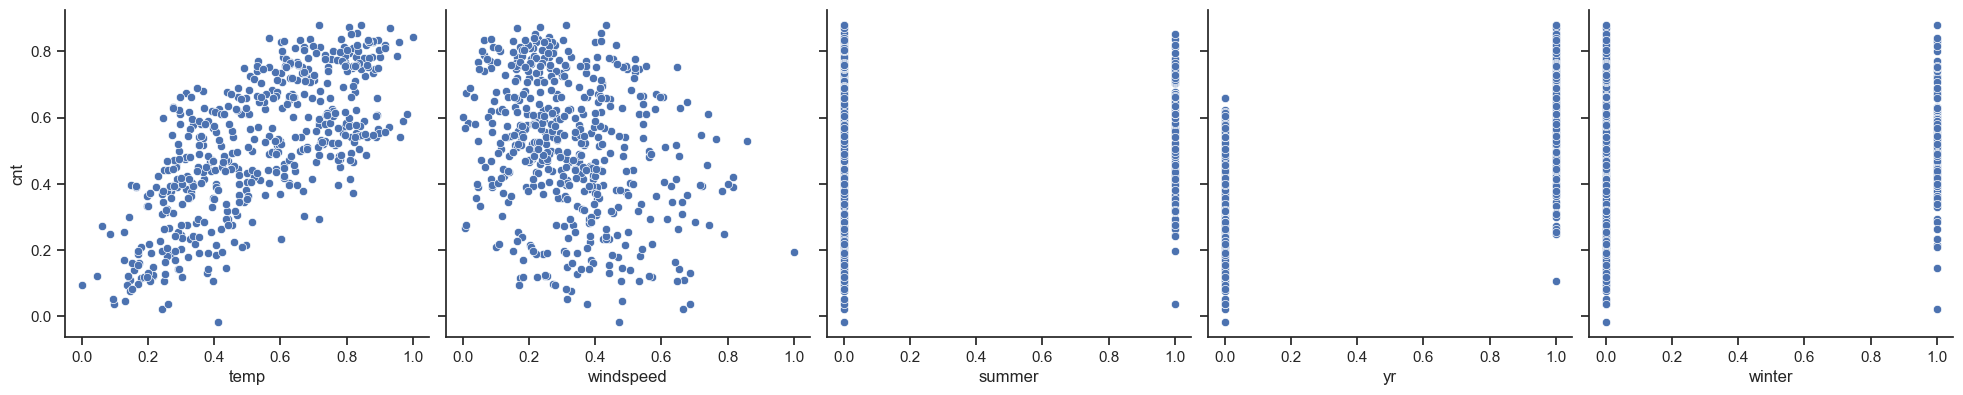

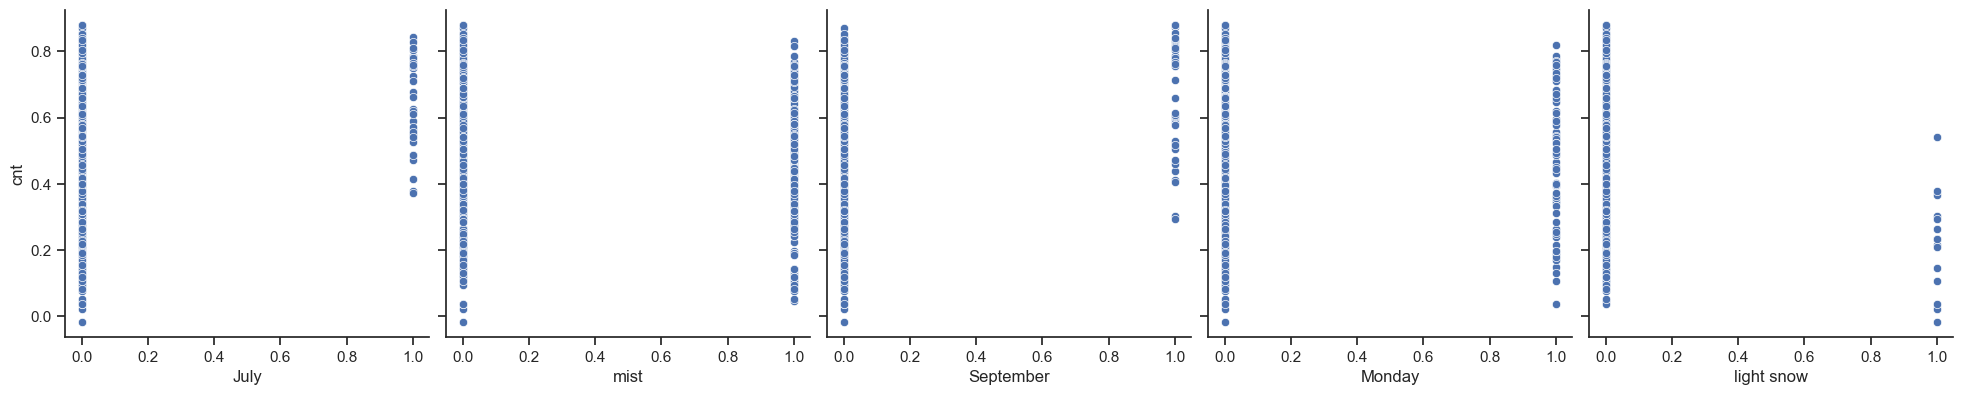

In [42]:
y_bikesharing_pred = y_bikesharing_train_pred.to_frame(name='cnt')
merged_df = pd.concat([x_bikesharing_rfe_train_sm, y_bikesharing_pred], axis=1)

# Create a pair plot
sns.set(style="ticks")
sns.pairplot(merged_df, x_vars=['temp', 'windspeed', 'summer', 'yr', 'winter'], 
             y_vars=['cnt'], height=4)
sns.pairplot(merged_df, x_vars=['July', 'mist', 'September', 'Monday', 'light snow'], 
             y_vars=['cnt'], height=4)
plt.show()

### Observations
- It can be seen from the pair plots the linear relationship between the predicted target variable and different independent variables is very well retained like in the original dataset.

# 5. Making Predictions for Test Data

In [43]:
# Scaling the variables in test data
bikesharing_test_df[variables_to_scale]=scaler.transform(bikesharing_test_df[variables_to_scale])

# Taking the final varibales from train set into test set
x_test_columns=x_bikesharing_rfe_train.columns

# Extracting out x and y variable in the test set
y_bikesharing_test=bikesharing_test_df.pop('cnt')
x_bikesharing_test_sm=sm.add_constant(bikesharing_test_df[x_test_columns])

x_bikesharing_test_sm.head()

# Calculating y_pred on test data using the linear model
y_bikesharing_test_pred=linearModel.predict(x_bikesharing_test_sm)
y_bikesharing_test_pred


184    0.470264
535    0.904789
299    0.407110
221    0.586726
152    0.572130
         ...   
400    0.326479
702    0.733672
127    0.482615
640    0.798158
72     0.268358
Length: 219, dtype: float64

# 6. Evaluating the model using r2_score and plotting the scatter plot

R2-score of train data 0.8360233701515918
R2-score of test data 0.8054076801738519


Text(0, 0.5, 'y_pred')

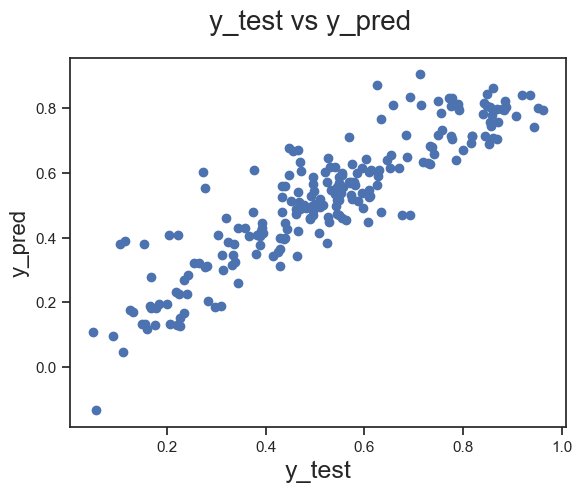

In [44]:
# r2_score for train data
print("R2-score of train data",r2_score(y_true=y_bikesharing_train, y_pred=y_bikesharing_train_pred))

# r2_score os test data
print("R2-score of test data",r2_score(y_true=y_bikesharing_test, y_pred=y_bikesharing_test_pred))


# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_bikesharing_test,y_bikesharing_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label


### Observations
- There is and acceptable difference in the r2 score of test data and train data which is 83.6-80.54 = 3.06%. This indicates that the model is a good fit.
- The plot between y_Test and y_test_pred is also linear indicating that the values are near to similar.